http://arxiv.org/pdf/1406.2661v1.pdf ...we simultaneously train two models: a generative model $G$
that captures the data distribution, and a discriminative model $D$ that estimates
the probability that a sample came from the training data rather than $G$. The training
procedure for $G$ is to maximize the probability of $D$ making a mistake...
we define a prior on input noise variables $p_z(z)$...
we simultaneously train G to minimize
$\log(1 − D(G(z)))$...

original code from https://gist.github.com/Newmu/4ee0a712454480df5ee3

You will need to install Foxhound:
```bash
git clone https://github.com/IndicoDataSolutions/Foxhound.git
cd Foxhound/
python setup.py install
```

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from time import time
import theano
import theano.tensor as T
 
from scipy.stats import gaussian_kde
from scipy.misc import imsave, imread

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GT 650M


In [3]:
from foxhound import activations
from foxhound import updates
from foxhound import inits
from foxhound.theano_utils import floatX, sharedX

In [4]:
leakyrectify = activations.LeakyRectify()
rectify = activations.Rectify()
tanh = activations.Tanh()
sigmoid = activations.Sigmoid()
bce = T.nnet.binary_crossentropy
batch_size = 128
nh = 2048
init_fn = inits.Normal(scale=0.02)

In [5]:
def gaussian_likelihood(X, u=0., s=1.):
    return (1./(s*np.sqrt(2*np.pi)))*np.exp(-(((X - u)**2)/(2*s**2)))
 
def scale_and_shift(X, g, b, e=1e-8):
    X = X*g + b
    return X

build two networks

In [6]:
def g(X, w, g, b, w2, g2, b2, wo):
    h = leakyrectify(scale_and_shift(T.dot(X, w), g, b))
    h2 = leakyrectify(scale_and_shift(T.dot(h, w2), g2, b2))
    y = T.dot(h2, wo)
    return y
 
def d(X, w, g, b, w2, g2, b2, wo):
    h = rectify(scale_and_shift(T.dot(X, w), g, b))
    h2 = tanh(scale_and_shift(T.dot(h, w2), g2, b2))
    y = sigmoid(T.dot(h2, wo))
    return y

In [7]:
gw = init_fn((1, nh))
gg = inits.Constant(1.)(nh)
gg = inits.Normal(1., 0.02)(nh)
gb = inits.Normal(0., 0.02)(nh)
 
gw2 = init_fn((nh, nh))
gg2 = inits.Normal(1., 0.02)(nh)
gb2 = inits.Normal(0., 0.02)(nh)
 
gy = init_fn((nh, 1))
ggy = inits.Constant(1.)(1)
gby = inits.Normal(0., 0.02)(1)
 
dw = init_fn((1, nh))
dg = inits.Normal(1., 0.02)(nh)
db = inits.Normal(0., 0.02)(nh)
 
dw2 = init_fn((nh, nh))
dg2 = inits.Normal(1., 0.02)(nh)
db2 = inits.Normal(0., 0.02)(nh)
 
dy = init_fn((nh, 1))
dgy = inits.Normal(1., 0.02)(1)
dby = inits.Normal(0., 0.02)(1)
 
g_params = [gw, gg, gb, gw2, gg2, gb2, gy]
d_params = [dw, dg, db, dw2, dg2, db2, dy]

In [8]:
Z = T.matrix()
X = T.matrix()
 
gen = g(Z, *g_params)
 
p_real = d(X, *d_params)
p_gen = d(gen, *d_params)
 
d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()
 
d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d
 
cost = [g_cost, d_cost, d_cost_real, d_cost_gen]

In [9]:
lr = 0.001
lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt)
g_updater = updates.Adam(lr=lrt)
 
d_updates = d_updater(d_params, d_cost)
g_updates = g_updater(g_params, g_cost)
updates = d_updates + g_updates
 
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_train_both = theano.function([X, Z], cost, updates=updates)
_gen = theano.function([Z], gen)
_score = theano.function([X], p_real)
_cost = theano.function([X, Z], cost)

In [10]:
from IPython import display

def vis(i):
    s = 1.
    u = 0.
    zs = np.linspace(-1, 1, 500).astype('float32')
    xs = np.linspace(-5, 5, 500).astype('float32')
    ps = gaussian_likelihood(xs, 1.)
 
    gs = _gen(zs.reshape(-1, 1)).flatten()
    preal = _score(xs.reshape(-1, 1)).flatten()
    kde = gaussian_kde(gs)
 
    plt.clf()
    plt.plot(xs, ps, '--', lw=2)
    plt.plot(xs, kde(xs), lw=2)
    plt.plot(xs, preal, lw=2)
    plt.xlim([-5., 5.])
    plt.ylim([0., 1.])
    plt.ylabel('Prob')
    plt.xlabel('x')
    plt.legend(['P(data)', 'G(z)', 'D(x)'])
    plt.title('GAN learning guassian %d'%i)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

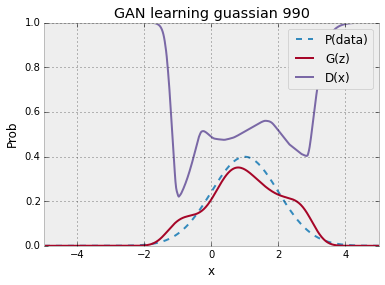

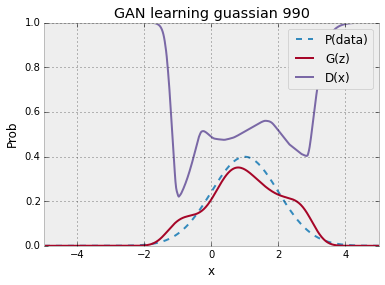

In [11]:
for i in range(1000):
    # the prior over the input noise
    zmb = np.random.uniform(-1, 1, size=(batch_size, 1)).astype('float32')
    xmb = np.random.normal(1., 1, size=(batch_size, 1)).astype('float32')
    if i % 10 == 0:
        # you dont really use xmb in training G
        _train_g(xmb, zmb)
    else:
        _train_d(xmb, zmb)
    if i % 10 == 0:
        vis(i)
    lrt.set_value(floatX(lrt.get_value()*0.9999))